In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
torch.cuda.is_available()

True

In [2]:
relevant_variables =  ['probeScEta', 'probeEtaWidth', 'probeR9', 'weight', 'probeSigmaRR',
       'tagChIso03', 'probeChIso03', 'probeS4', 'tagR9', 'tagPhiWidth_Sc',
       'probePt', 'tagSigmaRR', 'probePhiWidth', 'probeChIso03worst',
       'puweight', 'tagEleMatch', 'tagPhi', 'probeScEnergy', 'nvtx',
       'probePhoIso', 'tagPhoIso', 'run', 'tagScEta', 'probeEleMatch',
       'probeCovarianceIeIp', 'tagPt', 'rho', 'tagS4', 'tagSigmaIeIe',
       'tagCovarianceIpIp', 'tagCovarianceIeIp', 'tagScEnergy',
       'tagChIso03worst', 'probeSigmaIeIe', 'probePhi', 'mass',
       'probeCovarianceIpIp', 'tagEtaWidth_Sc', 'probeHoE',
       'probeFull5x5_e1x5', 'probeFull5x5_e5x5', 'probeNeutIso',
       'probePassEleVeto']


In [3]:
df_data = pd.read_hdf("samples/df_data_EB_train.h5", columns=relevant_variables)
df_mc = pd.read_hdf("samples/df_mc_EB_train.h5",columns=relevant_variables)

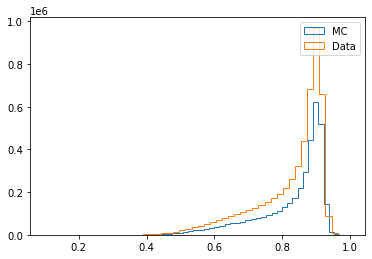

In [4]:
plt.hist(df_mc.probeS4, bins=50, histtype="step", label="MC")
plt.hist(df_data.probeS4, bins=50, histtype="step", label="Data")
plt.legend()

In [5]:
# variables to transform
tr_vars = ["probeS4", "probeR9", "probeCovarianceIeIp", "probeCovarianceIpIp","probeSigmaIeIe"]
# variables to use for conditioning
cond_vars = ['probePt','probeScEta','probePhi','rho']

In [21]:
N= 100000
df_data_tr = df_data[tr_vars][0:N]
df_data_cond = df_data[cond_vars][0:N]
df_mc_tr = df_mc[tr_vars][0:N]
df_mc_cond = df_mc[cond_vars][0:N]

In [10]:
df_mc_tr["label"] = 1
df_data_tr["label"] = 0

In [19]:
df = pd.concat([df_mc_tr, df_data_tr], axis=0)
df = df.reset_index()

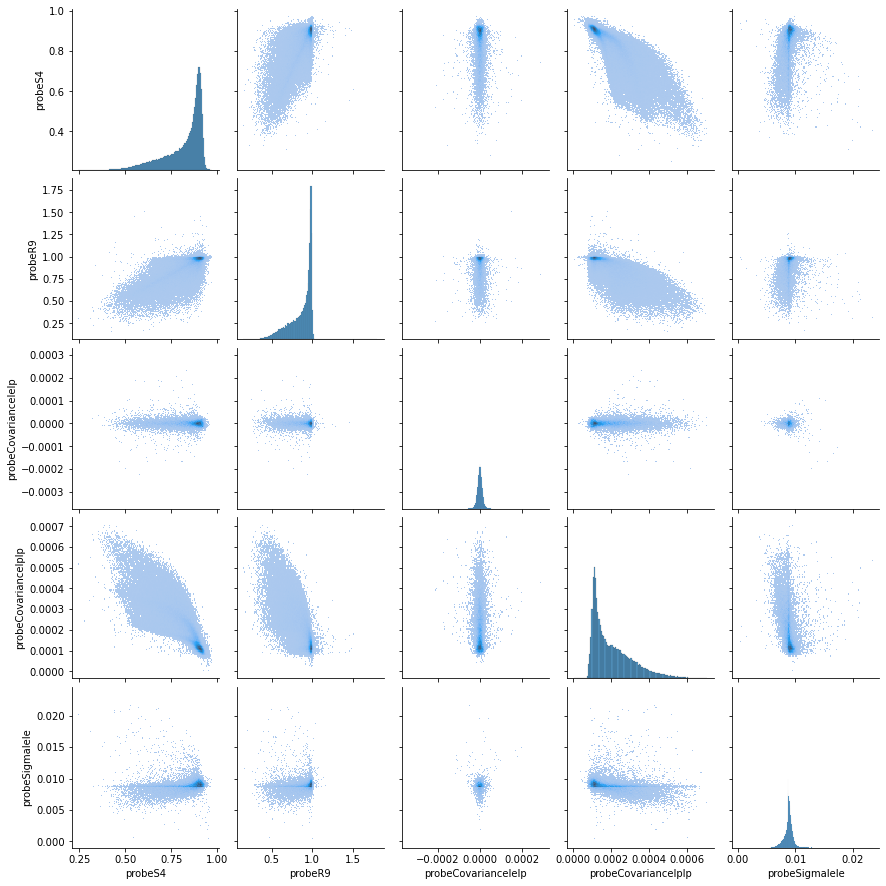

In [22]:
sns.pairplot(df_data_tr,kind="hist")

## NFlow

In [76]:
import normflow as nf

# Define 2D base distribution
base = nf.distributions.base.DiagGaussian(N_vars)

# Define list of flows
num_layers = 16
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(np.ceil(N_vars/2)), 32, 32, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(N_vars, mode='swap'))

In [77]:
# If the target density is not given
model = nf.NormalizingFlow(base, flows)

# If the target density is given
#target = nf.distributions.target.TwoMoons()
#model = nf.NormalizingFlow(base, flows, target)

In [78]:
model

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
            (net): Sequential(
              (0): Linear(in_features=3, out_features=32, bias=True)
              (1): LeakyReLU(negative_slope=0.0)
              (2): Linear(in_features=32, out_features=32, bias=True)
              (3): LeakyReLU(negative_slope=0.0)
              (4): Linear(in_features=32, out_features=2, bias=True)
            )
          )
        )
        (2): Merge()
      )
    )
    (1): Permute()
    (2): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
            (net): Sequential(
              (0): Linear(in_features=3, out_features=32, bias=True)
              (1): LeakyReLU(negative_slope=0.0)
              (2): Linear(in_features=32, out_features=32, bias=True)
              (3): Le

In [89]:
x = torch.from_numpy(df_data_tr.values)
x.to("cpu")

tensor([[ 8.4643e-01,  8.9966e-01, -9.1482e-06,  1.9191e-04,  9.2234e-03],
        [ 8.9852e-01,  9.8405e-01,  3.3531e-06,  1.1496e-04,  1.0424e-02],
        [ 7.7796e-01,  7.7774e-01,  1.5262e-05,  3.9593e-04,  7.3185e-03],
        ...,
        [ 9.0613e-01,  9.4988e-01, -3.6686e-06,  1.0313e-04,  8.6814e-03],
        [ 8.9780e-01,  8.9126e-01,  7.9280e-06,  1.1491e-04,  9.9002e-03],
        [ 9.0030e-01,  7.4509e-01,  2.3990e-05,  1.4745e-04,  9.3876e-03]])

In [93]:
# When doing maximum likelihood learning, i.e. minimizing the forward KLD
# with no target distribution given
loss = model.forward_kld(x)

In [94]:
loss

tensor(5.3141, grad_fn=<NegBackward>)

In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [95]:
# Optimization as usual
loss.backward()
optimizer.step()

In [ ]:
train(model, loss, optimizer, 0, 40, 
    trainloader, valloader, train_batch_size, 
      val_batch_size, is_gpu=True)

In [96]:
def train(net, criterion, optimizer, start_epoch, epochs, trainloader, 
          valloader, train_batch_size, val_batch_size, is_gpu=True):
    """
    Training process.
    Args:
        net: Triplet Net
        criterion: TripletMarginLoss
        optimizer: SGD with Nesterov Momentum
        trainloader: training set loader
        valloader: validation set loader
        start_epoch: 0
        epochs: number of training epochs
        is_gpu: True since we train on GPU
    """
    print("Start training...")

    criterion_val = nn.TripletMarginLoss(margin=0.0, p=2, reduction='none')
    net.train()
    
    for epoch in range(start_epoch, epochs + start_epoch):

        running_loss = 0.0
        loss_train = 0.0
        for batch_idx, (data1, data2, data3) in enumerate(trainloader):

            if is_gpu:
                data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

            # wrap in torch.autograd.Variable
            data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

            # compute output and loss
            embedded_a, embedded_p, embedded_n = net(data1, data2, data3)
            loss = criterion(embedded_a, embedded_p, embedded_n)

            # compute gradient and do optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print the loss
            running_loss += loss.data

            loss_train_cls = torch.sum(1 * (criterion_val(embedded_a, embedded_p, embedded_n) > 0)) / train_batch_size

            loss_train += loss_train_cls.data

            if batch_idx % 30 == 0:
                print(f"mini Batch Loss: {loss.data}")

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        loss_train /= len(trainloader)

        print(f"Training Epoch: {epoch + 1} | Loss: {running_loss}")
        print(f"Training Epoch: {epoch + 1} | Class. Loss: {loss_train}")

        # Validation
        net.eval()
        val_loss = 0.0
        for batch_idx, (data1, data2, data3) in enumerate(valloader):
            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

            # wrap in torch.autograd.Variable
            data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

            with torch.no_grad():
                # compute output and loss
                embedded_a, embedded_p, embedded_n = net(data1, data2, data3)
                loss_val = torch.sum(1 * (criterion_val(embedded_a, embedded_p, embedded_n) > 0)) / val_batch_size
                val_loss += loss_val.data

        val_loss /= len(valloader)
        print(f"Validation Epoch: {epoch + 1} | Class. Loss: {val_loss}")
        # Go back to training mode, see https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
        net.train()

    print("Finished Training...")
    net.eval()

    return net